In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from __future__ import print_function
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Project2/Project 2/data/data_normalized.csv', encoding='utf-8')
df.head()


,review,sentiment,word count
0,one review mention watch 1 oz episod hook righ...,1,162
1,wonder littl product film techniqu unassum old...,1,86
2,thought wonder way spend time hot summer weeke...,1,85
3,basic famili littl boy jake think zombi closet...,0,66
4,petter mattei love time money visual stun film...,1,125


# New Section

In [6]:
X = df['review']
Y = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print("Training set has {} examples.".format(x_train.shape[0]))
print("Testing set has {} examples.".format(x_test.shape[0]))

Training set has 34700 examples.
Testing set has 14872 examples.


## Support Vector Machine

# New Section

In [7]:
steps = []
steps.append(('CountVectorizer', CountVectorizer(ngram_range=(1,5) ,max_df=0.5, min_df=5)))
steps.append(('tfidf', TfidfTransformer(use_idf=False, sublinear_tf = True,norm='l2',smooth_idf=True)))
steps.append(('classifier',  LinearSVC(dual=False, penalty="l2", loss='squared_hinge')))
clf = Pipeline(steps)
start = time.time()
clf.fit(x_train, y_train)
end = time.time()
y_pred = clf.predict(x_test)
report = metrics.classification_report(y_test, y_pred, labels=[1,0], digits=3)

In [8]:
print('Train', report)
print('Time train: ', end - start)


Train               precision    recall  f1-score   support

           1      0.889     0.911     0.900      7427
           0      0.909     0.887     0.898      7445

    accuracy                          0.899     14872
   macro avg      0.899     0.899     0.899     14872
weighted avg      0.899     0.899     0.899     14872

Time train:  49.11072278022766


In [9]:
cross_score = cross_val_score(clf, x_train, y_train, cv=5)
print("CROSSVALIDATION 5 FOLDS: %0.4f (+/- %0.4f)" %
      (cross_score.mean(), cross_score.std() * 2))


CROSSVALIDATION 5 FOLDS: 0.8952 (+/- 0.0068)


In [10]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from __future__ import print_function
from wandb.keras import WandbCallback
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.preprocessing import text, sequence
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from keras.layers import LSTM, Bidirectional, Flatten, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.optimizers import Adam

In [12]:
import wandb

In [13]:
sent_freq = df['review'].apply(lambda x: len(str(x).split(" ")))
sent_freq.describe()

count    49572.000000
mean       119.448782
std         90.197891
min          3.000000
25%         64.000000
50%         89.000000
75%        145.000000
max       1429.000000
Name: review, dtype: float64

In [14]:
word_tokens_freq = df['review'].str.split(expand=True).stack().value_counts()
word_tokens_freq.describe()

count     72243.000000
mean         81.963858
std         871.949771
min           1.000000
25%           1.000000
50%           2.000000
75%          11.000000
max      102436.000000
dtype: float64

In [15]:
vocab_word = word_tokens_freq.index.tolist()
vocab_size = len(vocab_word)
print('Vocab size: ', vocab_size)

Vocab size:  72243


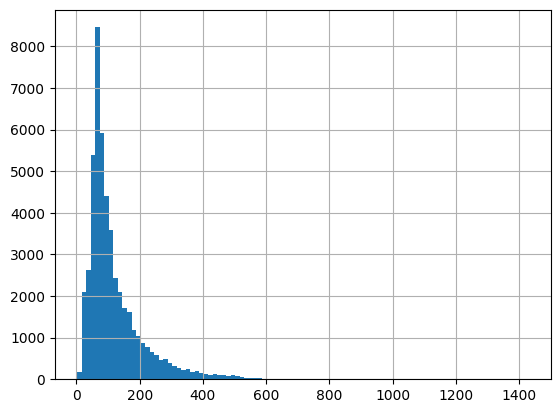

In [16]:
seq_len = [len(i.split()) for i in df['review']]
pd.Series(seq_len).hist(bins=100)
plt.show()

In [17]:
one_hot_dir = [one_hot(words, vocab_size)
               for words in df['review']]
print(one_hot_dir[0])
embedded_layer = pad_sequences(one_hot_dir, padding='pre')
y = to_categorical(df['sentiment'], num_classes=2)
x = np.array(embedded_layer)


[30376, 13756, 2805, 64714, 50023, 50760, 67665, 25997, 44516, 25887, 54216, 40650, 51574, 43266, 50760, 70764, 58514, 23677, 69571, 12863, 44516, 60583, 13362, 45887, 44016, 9085, 32666, 27792, 44016, 67482, 5013, 43792, 41969, 34850, 69571, 63419, 21648, 36154, 60583, 15686, 50760, 51798, 20168, 43682, 47525, 49472, 63368, 21538, 18415, 64277, 40570, 20408, 30305, 36031, 37243, 15411, 60283, 1298, 41440, 10742, 45901, 47589, 46102, 33539, 20408, 9082, 18108, 40245, 69950, 33824, 67901, 32814, 28520, 51221, 23753, 2207, 36894, 59345, 7716, 49130, 26264, 8652, 59865, 61602, 56904, 61382, 44887, 70813, 44016, 1153, 29848, 32460, 44016, 61159, 70484, 42803, 11857, 53216, 28199, 28001, 70484, 36531, 70484, 54472, 50760, 21468, 7506, 40650, 67665, 51405, 20054, 43266, 48752, 71433, 61382, 21802, 64714, 48908, 4589, 50760, 62444, 15461, 47589, 63114, 58674, 69571, 69571, 39374, 70404, 67389, 21640, 35413, 18088, 27802, 3388, 13111, 61602, 604, 26971, 4081, 36910, 18088, 54192, 37243, 23967,

In [18]:
x

array([[    0,     0,     0, ..., 15546, 16440, 43353],
       [    0,     0,     0, ...,  7577,   604, 47661],
       [    0,     0,     0, ..., 13362, 33899, 16224],
       ...,
       [    0,     0,     0, ..., 41603, 67575, 32814],
       [    0,     0,     0, ..., 10701, 44192,  9418],
       [    0,     0,     0, ..., 30141, 20491, 16454]], dtype=int32)

In [19]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.3, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42)

In [21]:
print("Training set has {} examples.".format(x_train.shape[0]))
print("Validation set has {} examples.".format(x_valid.shape[0]))
print("Testing set has {} examples.".format(x_test.shape[0]))

Training set has 31230 examples.
Validation set has 3470 examples.
Testing set has 14872 examples.


In [36]:
wandb.init()
config = wandb.config

config.vocab_size = vocab_size  # Số lượng từ vựng
config.maxlen = 500    # Độ dài tối đa của mỗi câu
config.batch_size = 32  # Kích thước của từng batch
config.embedding_dims = 200
config.filters = 32
config.kernel_size = 3
config.hidden_dims = 64
config.epochs = 10


accuracy,▁▄▆▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▆███▅▄▄▃▁▂
val_loss,▂▁▁▂▃▄▅▆▇█
accuracy,0.99334
best_epoch,1
best_val_loss,0.27795
epoch,9
loss,0.02205
val_accuracy,0.86254


In [37]:
from keras.preprocessing import text
tokenizer = text.Tokenizer(num_words=config.vocab_size, split=' ')
tokenizer.fit_on_texts(x_train)
X_train = tokenizer.texts_to_sequences(x_train)
X_valid = tokenizer.texts_to_sequences(x_valid)
X_test = tokenizer.texts_to_sequences(x_test)
X_train = pad_sequences(X_train, maxlen=config.maxlen)
X_valid = pad_sequences(X_valid, maxlen=config.maxlen)
X_test = pad_sequences(X_test, maxlen=config.maxlen)

X_train.shape, X_valid.shape, X_test.shape

((31230, 500), (3470, 500), (14872, 500))

In [38]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [39]:
model = Sequential()
model.add(Embedding(config.vocab_size,
          config.embedding_dims, input_length=config.maxlen))
model.add(Conv1D(config.filters, config.kernel_size,
          padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()
time_start = time.time()
history = model.fit(X_train, y_train, batch_size=config.batch_size, epochs=config.epochs,
          validation_data=(X_valid, y_valid), callbacks=[WandbCallback()])
time_end = time.time()
model.save('CNN1.h5')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 200)          14448600  
                                                                 
 conv1d_2 (Conv1D)           (None, 498, 32)           19232     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                      

wandb: Adding directory to artifact (/content/wandb/run-20230609_041902-fon4g32f/files/model-best)... Done. 8.0s


976/976 [==============================] - 139s 141ms/step - loss: 0.4158 - accuracy: 0.8057 - val_loss: 0.2869 - val_accuracy: 0.8801
Epoch 2/10
976/976 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9068

wandb: Adding directory to artifact (/content/wandb/run-20230609_041902-fon4g32f/files/model-best)... Done. 12.7s


976/976 [==============================] - 61s 63ms/step - loss: 0.2315 - accuracy: 0.9068 - val_loss: 0.2710 - val_accuracy: 0.8885
Epoch 3/10
976/976 [==============================] - 26s 27ms/step - loss: 0.1160 - accuracy: 0.9585 - val_loss: 0.2934 - val_accuracy: 0.8876
Epoch 4/10
976/976 [==============================] - 17s 17ms/step - loss: 0.0644 - accuracy: 0.9786 - val_loss: 0.3602 - val_accuracy: 0.8801
Epoch 5/10
976/976 [==============================] - 14s 14ms/step - loss: 0.0457 - accuracy: 0.9840 - val_loss: 0.3895 - val_accuracy: 0.8778
Epoch 6/10
976/976 [==============================] - 14s 14ms/step - loss: 0.0338 - accuracy: 0.9884 - val_loss: 0.4305 - val_accuracy: 0.8813
Epoch 7/10
976/976 [==============================] - 13s 14ms/step - loss: 0.0273 - accuracy: 0.9907 - val_loss: 0.4891 - val_accuracy: 0.8775
Epoch 8/10
976/976 [==============================] - 12s 13ms/step - loss: 0.0257 - accuracy: 0.9917 - val_loss: 0.5159 - val_accuracy: 0.8761
Epo

In [40]:
print('Time train: ', time_end - time_start)

Time train:  317.8685176372528


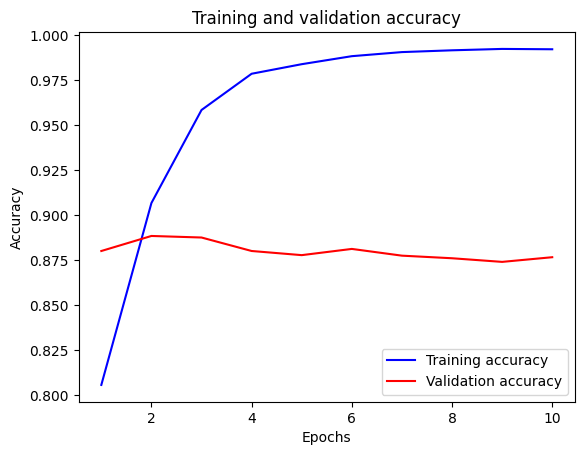

In [41]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = np.arange(1, len(accuracy)+1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
y_pred = model.predict(X_test)
y_pred = [[1 if x > 0.5 else 0] for x in y_pred]
report = metrics.classification_report(y_test, y_pred, digits=3)
print(report)


465/465 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0      0.881     0.847     0.864      7445
           1      0.853     0.885     0.869      7427

    accuracy                          0.866     14872
   macro avg      0.867     0.866     0.866     14872
weighted avg      0.867     0.866     0.866     14872

